In [1]:
%cd ..


/tempory/NeuralNetworksDIY


In [2]:
import os
import pickle
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from skimage import io, transform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.linear import Linear
from src.loss import *
from src.activation import TanH, Sigmoid, StableSigmoid, Softmax, LogSoftmax, ReLU, TanH, Softplus
from src.encapsulation import Sequential, Optim

np.random.seed(42)


/tempory/NeuralNetworksDIY/src/encapsulation.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


jouer avec les hpyerparam
espace latent
les initialisation 
plein de loss 
qu'est ce qui boost les perfs 

# Débruitage d'image plus petite

fashion mnist

In [3]:
def load_data(rootdir, class_list=None, trim: float = 0.5):
    def normalize_batch_image(X):
        mn = np.min(X)
        mx = np.max(X)
        X_norm = (X - mn) * (1.0 / (mx - mn))
        return X_norm

    train = pd.read_csv(os.path.join(rootdir, "fashion-mnist_train.csv"))
    # Filtering requested class
    if class_list:
        train = train[train["label"].isin(class_list)]
    y_train = train["label"].values
    X_train = train.drop(columns="label").values

    test = pd.read_csv(os.path.join(rootdir, "fashion-mnist_test.csv"))
    # Filtering requested class
    if class_list:
        test = test[test["label"].isin(class_list)]
    y_test = test["label"].values
    X_test = test.drop(columns="label").values

    trim_train = int(len(X_train) * trim)
    # trim_test = int(len(X_test) * trim)
    trim_test = int(len(X_test))

    # Normalization + trimming
    X_train = normalize_batch_image(X_train[:trim_train, :])
    X_test = normalize_batch_image(X_test[:trim_test, :])
    y_train = y_train[:trim_train]
    y_test = y_test[:trim_test]

    return (X_train, X_test, y_train, y_test)


rootdir = "./data/fashion-mnist/"
X_train, X_test, y_train, y_test = load_data(rootdir, trim=0.5)

y_train_oh = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_oh = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
nb_class = y_train_oh.shape[1]
batch_size = 64


In [4]:
def load_model(path):
    with open(path, "rb") as f:
        optimizer = pickle.load(f)
        net = optimizer.network
        loss_long_df = pd.melt(
            optimizer.train_df,
            id_vars="epoch",
            value_vars=["loss_test", "loss_train"],
            value_name="loss",
            var_name="during",
        ).replace({"loss_test": "test", "loss_train": "train"})
    return optimizer, net, loss_long_df


reconstruction simple 

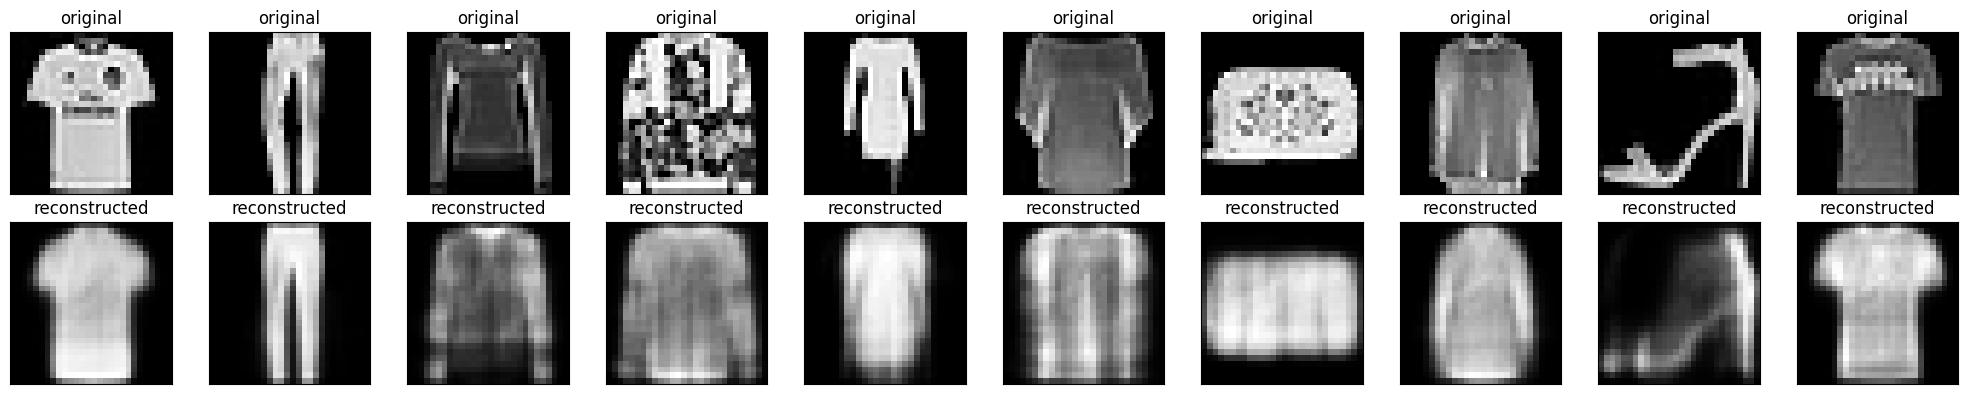

In [5]:
optimizer_simple, net_simple, loss_long_df_simple = load_model("./models/fashion-mnist_30_epoch_simple_net.pkl")

n = 10
decoded_imgs = net_simple.forward(X_test)
fig = plt.figure(figsize=(20, 4))
fig.set_tight_layout(True)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Reconstruction par epoch réseau simple

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

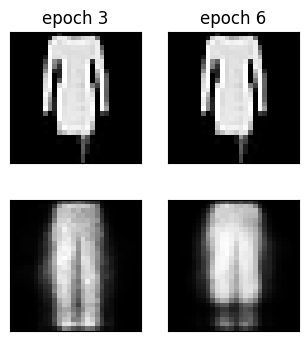

In [6]:
plt.figure(figsize=(20, 4))
fig.set_tight_layout(True)
optimizer_simple.network.reset()
n = 10
for i in range(n):
    optimizer_simple.SGD(
        X_train,
        X_train,
        batch_size,
        3,
    )
    decoded_imgs = optimizer_simple.network.forward(X_test)

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[4].reshape(28, 28))
    plt.title(f"epoch {(i+1)*3}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[4].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
fig.savefig('reports/src/reconstruction_per_epoch.pdf',
            dpi=100, bbox_inches="tight")

Does the middle activation funct impact reconstruction performance ? ~15 min 

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Batch:   0%|          | 0/314 [00:00<?, ?it/s]

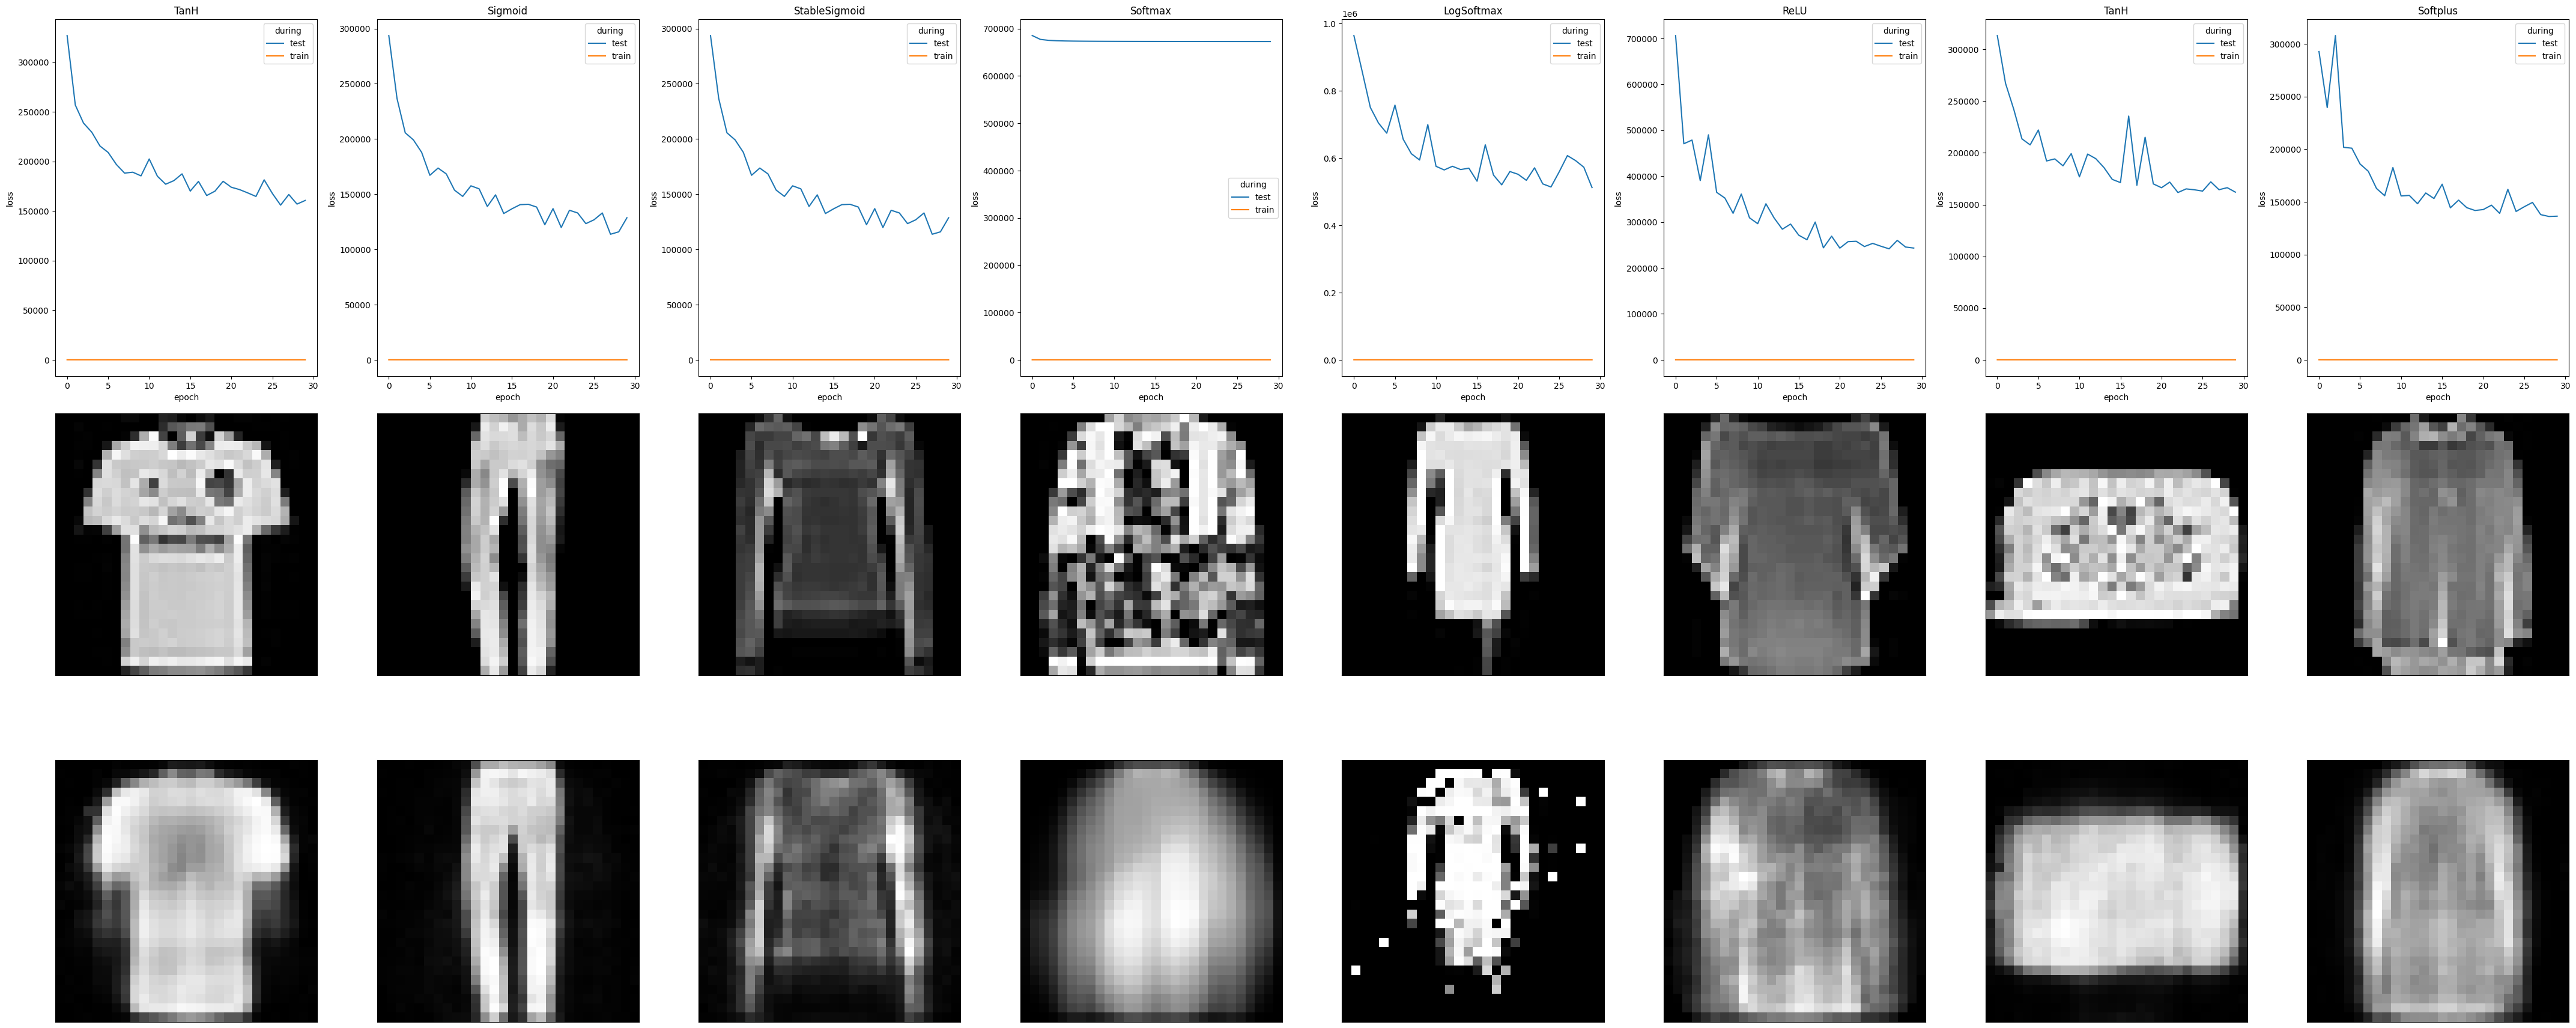

In [ ]:
fig, ax = plt.subplots(ncols=8, nrows=3, figsize=(43, 18))
fig.set_tight_layout(True)

for i, act_func in enumerate([TanH, Sigmoid, StableSigmoid, Softmax, LogSoftmax, ReLU, TanH, Softplus]):
    try:
        ax_col = ax[:, i]
        ax_col[0].set_title(act_func.__name__)

        encoder = [
            Linear(784, 64),
            act_func(),
        ]
        decoder = [
            Linear(64, 784),
            Sigmoid()
        ]
        net = Sequential(*(encoder + decoder))
        optimizer = Optim(net.reset(), MSELoss(), eps=1e-3)
        result_df = optimizer.SGD_eval(
            X_train,
            X_train,
            batch_size,
            30,
            test_size=0.33,
            return_dataframe=True,
            patience=None,
        )

        decoded_imgs = net.forward(X_test)
        loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=[
                               'loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
        sns.lineplot(loss_long_df, x='epoch', y='loss',
                     hue='during', ax=ax_col[0])
        # display original
        ax_col[1].imshow(X_test[i].reshape(28, 28), cmap='gist_gray')
        # ax_col[1].set_title("original")
        ax_col[1].get_xaxis().set_visible(False)
        ax_col[1].get_yaxis().set_visible(False)

        # display reconstruction
        ax_col[2].imshow(decoded_imgs[i].reshape(28, 28), cmap='gist_gray')
        # ax_col[2].set_title("reconstructed")
        ax_col[2].get_xaxis().set_visible(False)
        ax_col[2].get_yaxis().set_visible(False)
    except KeyError:
        continue
fig.savefig('reports/src/encoder_decoder_middle_func_simple_net.pdf',
            dpi=100, bbox_inches="tight")

## Réseau plus complexe

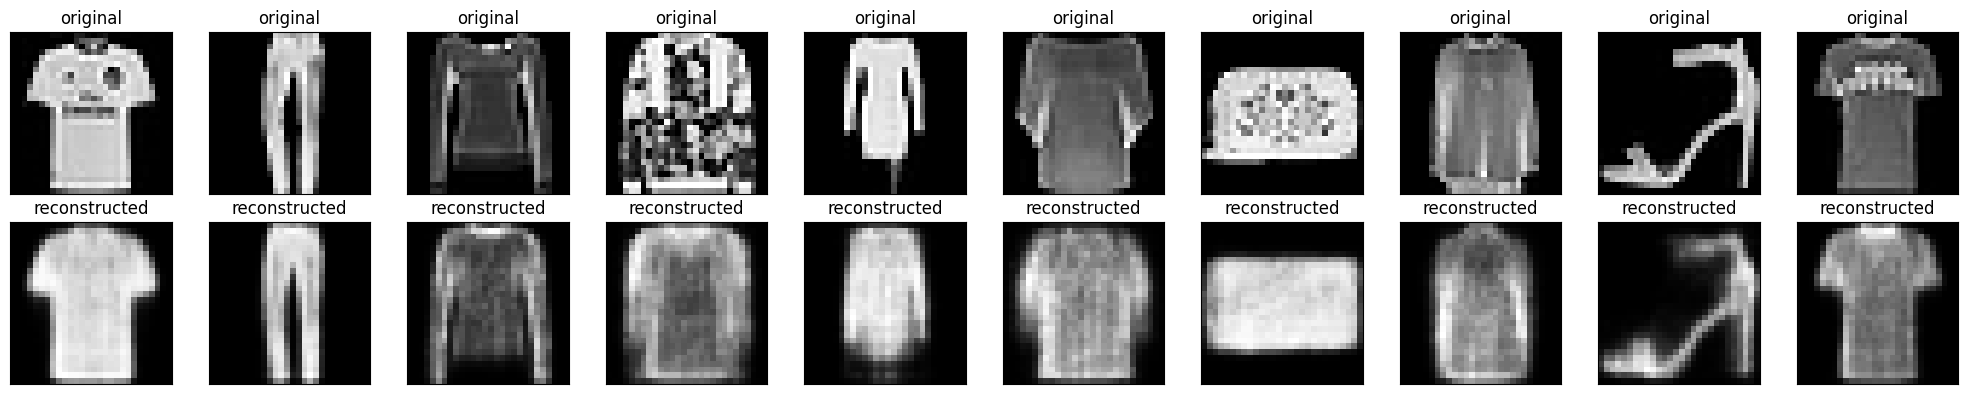

In [7]:
optimizer_cplx, net_medium, loss_long_df_medium  = load_model("./models/fashion-mnist_30_epoch_medium_net.pkl")

n = 10
decoded_imgs = net_medium.forward(X_test)
fig = plt.figure(figsize=(20, 4))
fig.set_tight_layout(True)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


réseau encore plus complexe

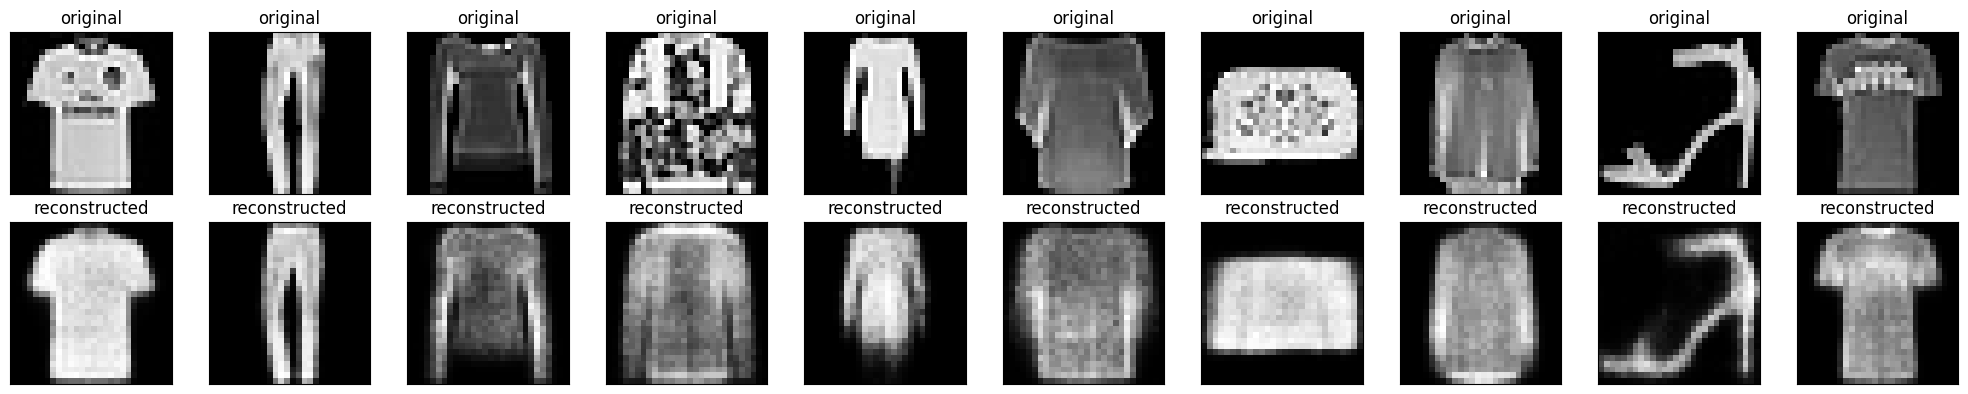

In [8]:
optimizer_big, net_big, loss_long_df_big = load_model("./models/fashion-mnist_30_epoch_big_net.pkl")

n = 10
decoded_imgs = net_big.forward(X_test)
fig = plt.figure(figsize=(20, 4))
fig.set_tight_layout(True)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


recontruction par epoch réseau très complexe 

In [ ]:
plt.figure(figsize=(20, 4))
fig.set_tight_layout(True)
optimizer.network.reset()
n = 10
for i in range(n):
    optimizer.SGD(
        X_train,
        X_train,
        batch_size,
        3,
    )
    decoded_imgs = optimizer.network.forward(X_test)

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[4].reshape(28, 28))
    plt.title(f"epoch {(i+1)*3}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[4].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
fig.savefig('reports/src/reconstruction_per_epoch_reseau_tres_cplx.pdf',
            dpi=100, bbox_inches="tight")

# Figure des loss

In [9]:
sns.set_theme(context="talk", style='whitegrid', palette="deep")

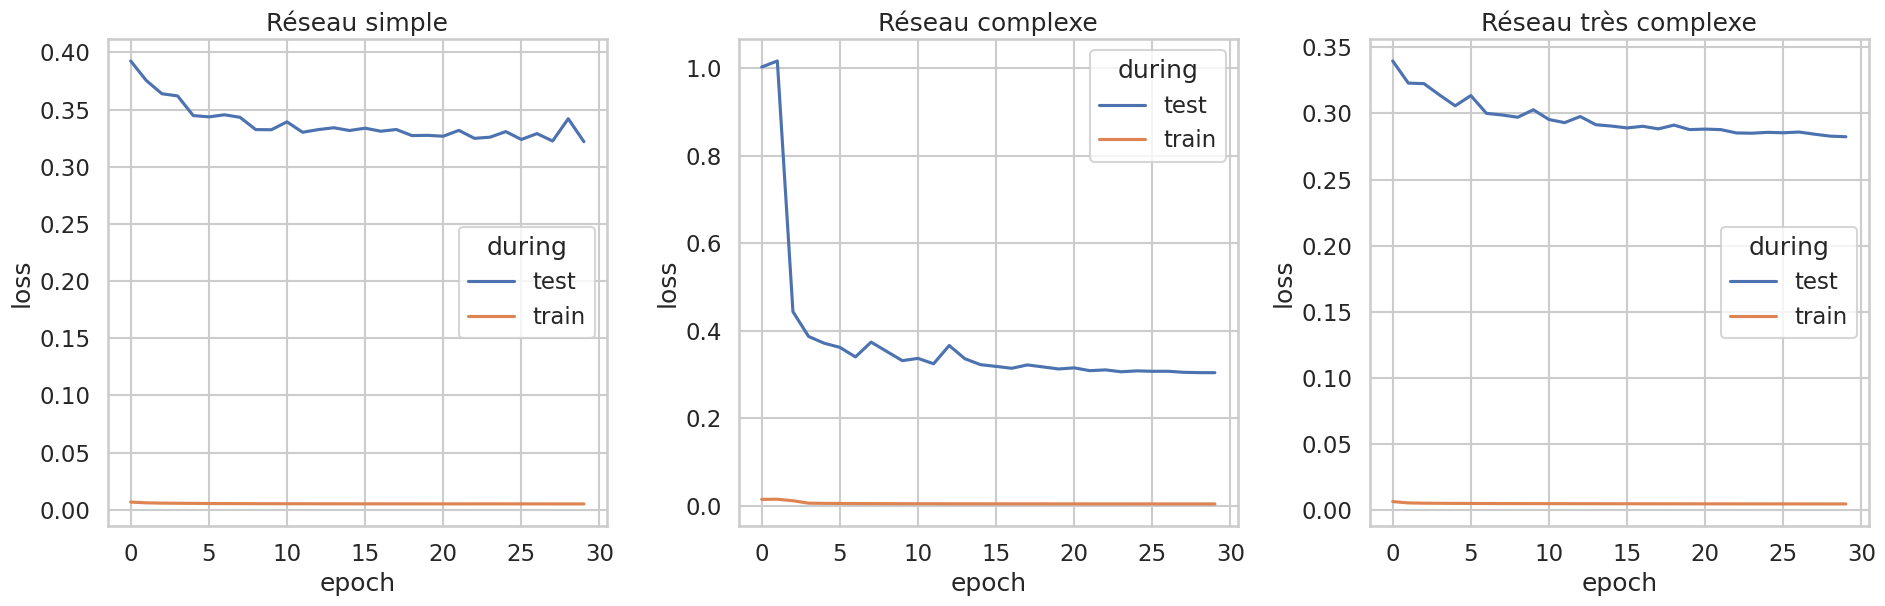

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(6.4*3, 6.4))
fig.set_tight_layout(True)

sns.lineplot(data=loss_long_df_simple, x="epoch", y="loss", hue="during", ax=ax[0])
ax[0].set_title('Réseau simple')
# ax[0].yaxis.set_ticks(np.arange(0, 1, 0.05))

sns.lineplot(data=loss_long_df_medium, x="epoch", y="loss", hue="during", ax=ax[1])
ax[1].set_title('Réseau complexe')
# ax[1].yaxis.set_ticks(np.arange(0, 1, 0.05))

sns.lineplot(data=loss_long_df_big, x="epoch", y="loss", hue="during", ax=ax[2])
ax[2].set_title('Réseau très complexe')
# ax[2].yaxis.set_ticks(np.arange(0, 1, 0.05))

fig.savefig('reports/src/loss_encoder_fashion_3_networks.pdf', dpi=100, bbox_inches="tight")

# Figure Reconstruiction différent réseau

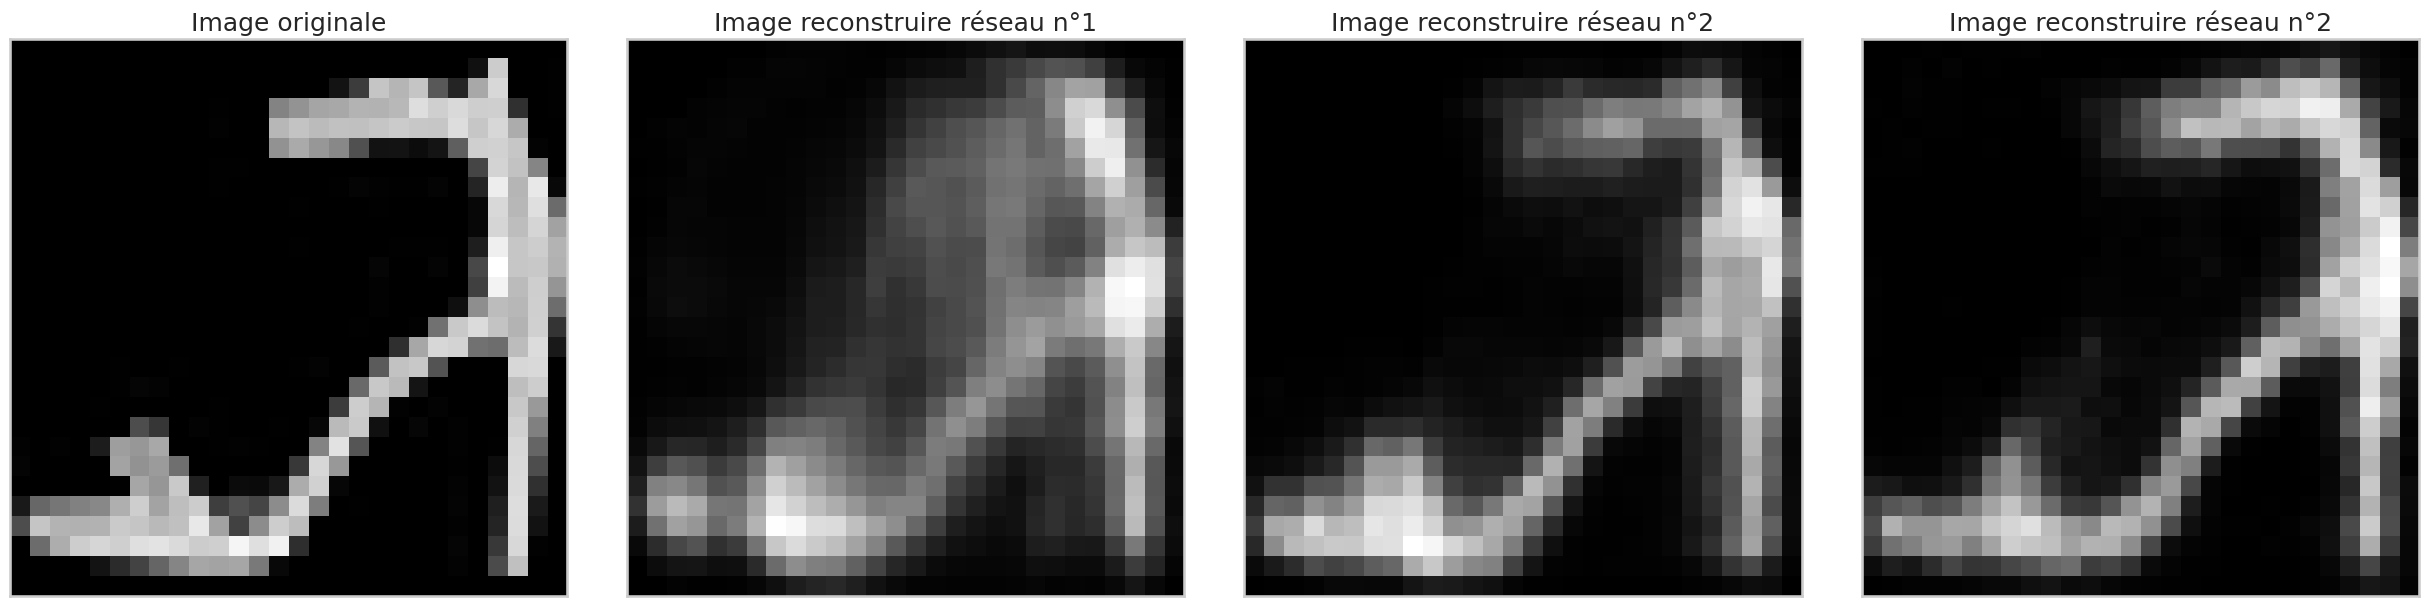

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(6.4*4, 6.4))
fig.set_tight_layout(True)
nb = 8

ax[0].imshow(X_test[nb].reshape(28, 28), cmap='gist_gray')
ax[0].set_title(f"Image originale", size=12*1.5)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(net_simple.forward(X_test)[nb].reshape(28, 28), cmap='gist_gray')
ax[1].set_title(f"Image reconstruire réseau n°1", size=12*1.5)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[2].imshow(net_medium.forward(X_test)[nb].reshape(28, 28), cmap='gist_gray')
ax[2].set_title(f"Image reconstruire réseau n°2", size=12*1.5)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

ax[3].imshow(net_big.forward(X_test)[nb].reshape(28, 28), cmap='gist_gray')
ax[3].set_title(f"Image reconstruire réseau n°2", size=12*1.5)
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)

fig.savefig('reports/src/reconstruction_per_network_cplxity.pdf', dpi=100, bbox_inches="tight")

---